In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
with open('E:/百度/train+cnn.txt', encoding='utf8') as file:
    line_list1 = [k.strip() for k in file.readlines()]
    #读取每行
    train_label_list = [k.split()[0] for k in line_list1]
    #将标签依次取出
    train_content_list = [k.split(maxsplit=1)[1] for k in line_list1]
    #将内容依次取出,此处注意split()选择最大分割次数为1,否则句子被打断.
with open('E:/百度/test+cnn.txt', encoding='utf8') as file:
    line_list2 = [k.strip() for k in file.readlines()]
    test_label_list = [k.split()[0] for k in line_list2]
    test_content_list = [k.split(maxsplit=1)[1] for k in line_list2]
with open('E:/百度/val+cnn.txt', encoding='utf8') as file:
    line_list3 = [k.strip() for k in file.readlines()]
    val_label_list = [k.split()[0] for k in line_list3]
    val_content_list = [k.split(maxsplit=1)[1] for k in line_list3]

In [3]:
from keras.utils import plot_model
from keras.layers import Embedding
import gensim
from gensim.models.word2vec import Word2Vec,LineSentence,Text8Corpus

Using TensorFlow backend.
C:\Users\hkdw235\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
model = Word2Vec.load('C:/Users/hkdw235/PycharmProjects/untitled/THUCNews/cont.model')

In [5]:
word_vectors = model.wv

In [6]:
EMBEDDING_DIM = 128 # 词向量空间维度
num_classes=10 # 类型数量
maxlen=600 # 文本长度
max_words=10000 # 词汇表数量

In [7]:
embeddings_index = {}
for word, vocab_obj in model.wv.vocab.items():
    if int(vocab_obj.index) < max_words:
        embeddings_index[word] = word_vectors[word]
del model, word_vectors # 删掉gensim模型释放内存
print('Found %s word vectors.' % len(embeddings_index))

Found 10000 word vectors.


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [9]:
tokenizer = Tokenizer(num_words=max_words) # 传入我们词向量的字典
content_list=train_content_list+test_content_list+val_content_list
tokenizer.fit_on_texts(content_list) # 传入我们的训练数据，得到训练数据中出现的词的字典
sequences1 = tokenizer.texts_to_sequences(train_content_list) # 根据训练数据中出现的词的字典，将训练数据转换为sequences
sequences2 = tokenizer.texts_to_sequences(test_content_list) # 根据训练数据中出现的词的字典，将训练数据转换为sequences
sequences3 = tokenizer.texts_to_sequences(val_content_list) # 根据训练数据中出现的词的字典，将训练数据转换为sequences
word_index = tokenizer.word_index
print('Found %s unique tokens2.' % len(word_index))

Found 383707 unique tokens2.


In [10]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
train_Y = to_categorical(label.fit_transform(train_label_list),num_classes=num_classes)
test_Y = to_categorical(label.fit_transform(test_label_list),num_classes=num_classes)
val_Y = to_categorical(label.fit_transform(val_label_list),num_classes=num_classes)

In [11]:
train_X = pad_sequences(sequences1,maxlen=maxlen,truncating='post',padding='post') # 和原作者的不同
test_X = pad_sequences(sequences2,maxlen=maxlen,truncating='post',padding='post') # 和原作者不同 
val_X = pad_sequences(sequences3,maxlen=maxlen,truncating='post',padding='post') # 和原作者不同 

In [12]:
from keras.models import Sequential 
from keras import layers
from keras.initializers import he_normal


In [13]:
embedding_matrix = np.zeros((max_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # 文本数据中的词在词向量字典中没有，向量为取0；如果有则取词向量中该词的向量
        embedding_matrix[i] = embedding_vector

In [15]:
model = Sequential()
# 将预训练好的词向量加载如embedding layer
# 我们设置 trainable = False，代表词向量不作为参数进行更新
embedding_layer = model.add(layers.Embedding(max_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False))
con=model.add(layers.Conv1D(filters=256,kernel_size=8))
maxpool=model.add(layers.MaxPooling1D(593))
flatten=model.add(layers.Flatten())
dense1=model.add(layers.Dense(128,activation='relu',kernel_initializer='glorot_normal'))  # 64是输出层的维度
dropout=model.add(layers.Dropout(0.2))  # 控制需要断开的神经元比例，此处应该为0.2
dense2=model.add(layers.Dense(10))
predict_y=model.add(layers.core.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 128)          1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 593, 256)          262400    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
__________

In [16]:
from keras import optimizers
optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['categorical_accuracy'] )

In [17]:
import random
for i in range(5000):
    train_index = random.sample(list(range(len(train_Y))),k=200)
    X = train_X[train_index]
    Y = train_Y[train_index]
    model.fit(X,Y,verbose=0)
    step = i + 1 
    if step % 100 == 0:
        val_index = random.sample(list(range(len(val_Y))), k=100)
        x = val_X[val_index]
        y = val_Y[val_index]
        loss_value, accuracy_value = model.evaluate(x,y,verbose=0)
        print('step:%d loss:%.4f accuracy:%.4f' %(step, loss_value, accuracy_value))

step:100 loss:0.1741 accuracy:0.9500
step:200 loss:0.2486 accuracy:0.9300
step:300 loss:0.0661 accuracy:0.9800
step:400 loss:0.0740 accuracy:0.9800
step:500 loss:0.1471 accuracy:0.9500
step:600 loss:0.0897 accuracy:0.9700
step:700 loss:0.1449 accuracy:0.9500
step:800 loss:0.0666 accuracy:0.9700
step:900 loss:0.1090 accuracy:0.9500
step:1000 loss:0.4559 accuracy:0.8500
step:1100 loss:0.2183 accuracy:0.9200
step:1200 loss:0.1290 accuracy:0.9700
step:1300 loss:0.1522 accuracy:0.9400
step:1400 loss:0.2824 accuracy:0.9200
step:1500 loss:0.2047 accuracy:0.9300
step:1600 loss:0.1409 accuracy:0.9600
step:1700 loss:0.2032 accuracy:0.9500
step:1800 loss:0.2698 accuracy:0.9400
step:1900 loss:0.2072 accuracy:0.9400
step:2000 loss:0.0890 accuracy:0.9500
step:2100 loss:0.0340 accuracy:0.9700
step:2200 loss:0.0533 accuracy:0.9900
step:2300 loss:0.0984 accuracy:0.9800
step:2400 loss:0.0511 accuracy:0.9900
step:2500 loss:0.2205 accuracy:0.9400
step:2600 loss:0.4184 accuracy:0.9100
step:2700 loss:0.1453

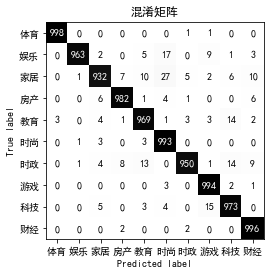

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import mglearn
import matplotlib.pyplot as plt
def predictAll(test_X, batch_size=100):
    predict_value_list = []
    for i in range(0, len(test_X), batch_size):
        X = test_X[i: i + batch_size]
        predict_value = model.predict(X)
        predict_value_list.extend(predict_value)
    return np.array(predict_value_list)

Y = predictAll(test_X)
y = np.argmax(Y, axis=1)
predict_label_list = label.inverse_transform(y)
score_image = mglearn.tools.heatmap(confusion_matrix(test_label_list, predict_label_list),
                                    xlabel='Predicted label',ylabel='True label',xticklabels=label.classes_,
                                    yticklabels=label.classes_,cmap=plt.cm.gray_r,fmt='%d')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('混淆矩阵')
plt.gca().invert_yaxis()
plt.show()

In [20]:
from sklearn.metrics import precision_recall_fscore_support

def eval_model(y_true, y_pred, labels):
    # 计算每个分类的Precision, Recall, f1, support
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred)
    # 计算总体的平均Precision, Recall, f1, support
    tot_p = np.average(p, weights=s)
    tot_r = np.average(r, weights=s)
    tot_f1 = np.average(f1, weights=s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        u'Label': labels,
        u'Precision': p,
        u'Recall': r,
        u'F1': f1,
        u'Support': s
    })
    res2 = pd.DataFrame({
        u'Label': ['总体'],
        u'Precision': [tot_p],
        u'Recall': [tot_r],
        u'F1': [tot_f1],
        u'Support': [tot_s]
    })
    res2.index = [999]
    res = pd.concat([res1, res2])
    return res[['Label', 'Precision', 'Recall', 'F1', 'Support']]

eval_model(test_label_list, predict_label_list, label.classes_)

,Label,Precision,Recall,F1,Support
0,体育,0.997003,0.998,0.997501,1000
1,娱乐,0.996894,0.963,0.979654,1000
2,家居,0.974895,0.932,0.952965,1000
3,房产,0.982000,0.982,0.982000,1000
4,教育,0.965139,0.969,0.967066,1000
5,时尚,0.946616,0.993,0.969253,1000
6,时政,0.987526,0.950,0.968400,1000
7,游戏,0.969756,0.994,0.981728,1000
8,科技,0.963366,0.973,0.968159,1000
9,财经,0.969815,0.996,0.982733,1000
